In [1]:
import gym
import ppaquette_gym_doom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.ndimage

In [2]:
env = gym.make('ppaquette/DoomHealthGathering-v0')

[2017-09-27 22:03:44,078] Making new env: ppaquette/DoomHealthGathering-v0


In [3]:
# Environment Parameters
n_actions = 3
n_episodes = 10000
render = False
train = True
actionRepeat = 3

# Environment Variables
states, actions, rewards = [], [], []
episode_num = 1
G = 0
reward = 0
average, avg_loss = [], []
counter = 1

# Hyper Parameters
learning_rate = 1e-5
gamma = .99
save_path='models/healthGather.ckpt'

# Conv Layers
convs = [16, 32]
kerns = [8, 4]
strides = [4, 2]
pads = 'VALID'
fc = 256

# TF Placeholders & Variables
X = tf.placeholder(tf.float32, shape=(None, 96, 96, 1), name="X")
Y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="Y")
eps_rewards = tf.placeholder(dtype=tf.float32, shape=[None,1], name="Episode_Discounted_Rewards")
tf_g = tf.Variable(0.0)

In [4]:
# CONVOLUTION 1 - 1
with tf.name_scope('conv1'):
    
    filter1 = tf.Variable(tf.truncated_normal([kerns[0], kerns[0], 1, convs[0]], dtype=tf.float32,
                            stddev=1/np.sqrt(96**2)), name='weights1')
    stride = [1,strides[0],strides[0],1]
    conv = tf.nn.conv2d(X, filter1, stride, padding=pads)
    biases = tf.Variable(tf.constant(0.0, shape=[convs[0]], dtype=tf.float32),
                         trainable=True, name='biases1')
    out = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(out)
    
    
# CONVOLUTION 1 - 2
with tf.name_scope('conv2'):
    shape = int(np.prod(conv1.get_shape()[1:]))
    filter2 = tf.Variable(tf.truncated_normal([kerns[1], kerns[1], convs[0], convs[1]], dtype=tf.float32,
                                                stddev=1/np.sqrt(shape)), name='weights2')
    stride = [1,strides[1],strides[1],1]
    conv = tf.nn.conv2d(conv1, filter2, stride, padding=pads)
    biases = tf.Variable(tf.constant(0.0, shape=[convs[1]], dtype=tf.float32),
                         trainable=True, name='biases2')
    out = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(out)
    

#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(conv2.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, fc], dtype=tf.float32, stddev=1/np.sqrt(shape)), name='weights3')
    fc1b = tf.Variable(tf.constant(1.0, shape=[fc], dtype=tf.float32),
                       trainable=True, name='biases3')
    flat = tf.reshape(conv2, [-1, shape])
    out = tf.nn.bias_add(tf.matmul(flat, fc1w), fc1b)
    fc_1 = tf.nn.relu(out)
    

#FULLY CONNECTED 2 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([fc, n_actions], dtype=tf.float32,
                                           stddev=1/np.sqrt(fc)), name='weights4')
    fc2b = tf.Variable(tf.constant(1.0, shape=[n_actions], dtype=tf.float32),
                       trainable=True, name='biases4')
    Ylogits = tf.nn.bias_add(tf.matmul(fc_1, fc2w), fc2b)
    output = tf.nn.softmax(Ylogits)


In [5]:
# Function for resizing image
def resize(image):
    # Greyscale Image
    x = np.mean(image,-1)
    # Crop Image
    x = x[:400,100:540]
    # Normalize Pixel Values
    x = x/255
    x = scipy.misc.imresize(x, [96,96])
    return(x)

In [6]:
# Apply discount to episode rewards & normalize
def discount_rewards(rewards, gamma):
    discount = np.zeros_like(rewards)
    G = 0
    for i in reversed(range(0, len(rewards))):
        G = G * gamma + rewards[i]
        discount[i] = G
    # Normalize 
    mean = np.mean(discount)
    std = np.std(discount)
    discount = (discount - mean) / (std)
    return discount


In [7]:
# Define loss
loss = -tf.log(output)*Y
loss_mean = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), 
                                    grad_loss=eps_rewards)
train = optimizer.apply_gradients(grads)

In [8]:
# Define Session and initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
# 
writer = tf.summary.FileWriter("/tmp/dpg")
writer.add_graph(sess.graph)
tf.summary.scalar('Loss', loss_mean)
tf.summary.scalar('Episode_Reward', tf_g)
tf.summary.histogram("Weights_1", filter1)
tf.summary.histogram("Weights_2", filter2)
write_op = tf.summary.merge_all()

In [10]:
# Load model if exists
saver = tf.train.Saver(tf.global_variables())
load_was_success = True 
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print("no saved model to load. starting new session")
    load_was_success = False
else:
    print("loaded model: {}".format(load_path))
    saver = tf.train.Saver(tf.global_variables())
    episode_num = int(load_path.split('-')[-1])+1

INFO:tensorflow:Restoring parameters from models/healthGather.ckpt-150


[2017-09-27 22:03:45,036] Restoring parameters from models/healthGather.ckpt-150


loaded model: models/healthGather.ckpt-150


In [11]:
# Define our three actions of moving forward, turning left & turning right
# If you want your agent to learn a good policy much faster 
# combine your turning actions with moving forward

choice = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

# This method learns a more intelligent method but takes much longer to train

#choice = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#          [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]


In [ ]:
state = resize(env.reset())

for i in range(10000):
    
    while True:
        if render:
            env.render()
        
        # Get action probability from network
        feed = {X:state.reshape(1, 96, 96, 1)}
        aprob = sess.run([output], feed_dict=feed)
        action = np.random.choice(n_actions, p=aprob[0][0])
        #print(aprob)
         
        # Convert action to one hot vector
        oneHot = np.zeros(n_actions)
        oneHot[action] = 1

        # Perform action loop & store results
        for i in range(actionRepeat):
            state2, reward2, done, info = env.step(choice[action])
            reward += reward2
        G += reward
        
        # Record history
        states.append(state)
        actions.append(oneHot)
        rewards.append(reward)
        reward = 0
        
        # Update current state
        state = resize(state2)
    
        if done:
            average.append(G)
            
            if G >= 2100:
                # Normalizing caused some high negative rewards for
                # completeing an episode, I thought this would help
                rewards = abs(discount_rewards(rewards,gamma))
            else:
                rewards = discount_rewards(rewards,gamma)
                
            # Define our network feed & measure average episode loss
            feed = {X: np.dstack(states).reshape(len(states),96,96,1), 
                    eps_rewards: np.vstack(rewards), 
                    Y: np.vstack(actions)}
            losses = sess.run([loss_mean], feed_dict=feed)
            avg_loss.append(losses)
            
            if episode_num % 1 == 0:
                print('Episode: {}   G:{:4.0f}  Average: {:4.1f}  Avg. Eps. Loss: {:4.4f}'
                      .format(episode_num, G, np.mean(average), losses[0]))
                
            if episode_num % 5 == 0:
                # Write TF Summaries
                tf_g = tf.assign(tf_g, G)
                sess.run(tf_g)
                summary = sess.run(write_op, feed_dict=feed)
                writer.add_summary(summary, episode_num)
                writer.flush()
            
            if episode_num % 50 == 0:
                # Save TensorFlow Variables 
                saver.save(sess, save_path, global_step=episode_num)
                print("SAVED MODEL #{}".format(episode_num))
                if counter >=100:
                    print('Last 100 Average {}'
                          .format(np.mean(average[counter-100:counter])))
            
            if train:
                # If train == True we will update the network every episode
                _ = sess.run([train], feed_dict=feed)
            
            
            # Reset our variables for next episode
            states, actions, rewards = [], [], []
            G = 0
            state = resize(env.reset())
            episode_num += 1
            counter += 1
            break
    
    if counter >=100:
        if np.sum(average[counter-100:counter])/100>=1700:
            print('Solved in {} Episodes'.format(episode_num))
            saver.save(sess, save_path, global_step=episode_num)
            print("SAVED MODEL #{}".format(episode_num))
            break
            
            

In [18]:
state = env.reset()


In [19]:
state = resize(state)

In [49]:
for i in range(20):
    state,_,_,_ = env.step(choice[0])
    env.render()

In [50]:
state = resize(state)

In [51]:
test = sess.run(conv1, feed_dict={X:state.reshape(1,96,96,1)})

In [52]:
test.shape

(1, 23, 23, 16)

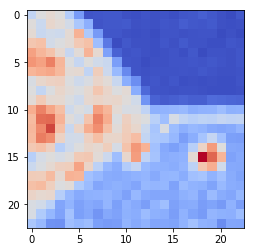

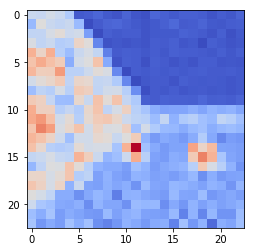

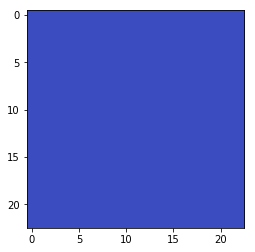

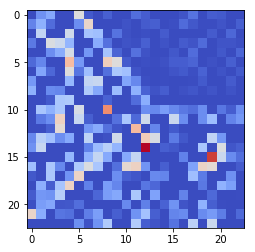

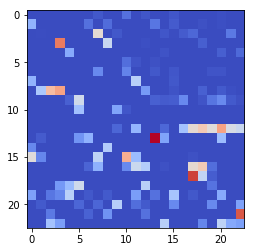

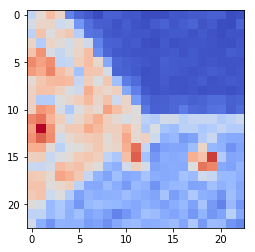

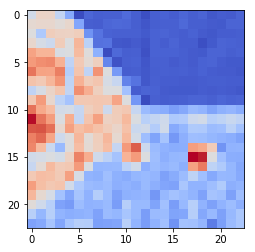

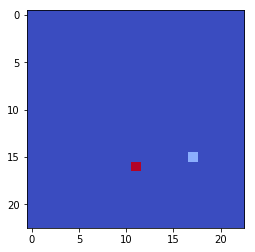

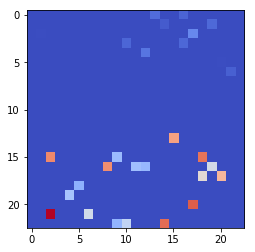

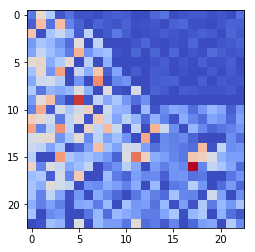

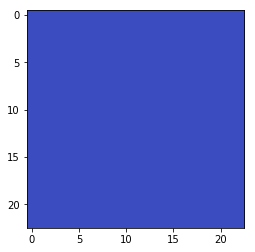

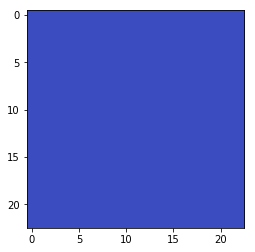

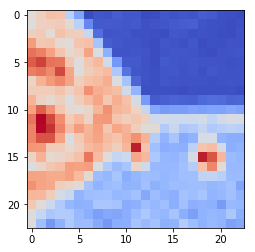

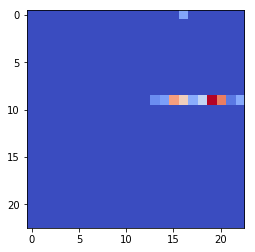

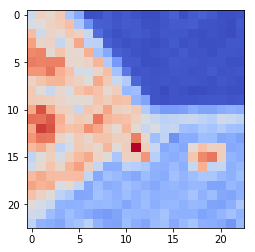

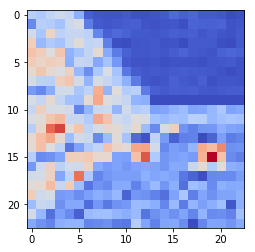

In [53]:
for i in range(16):
    plt.imshow(test[-1,:,:,i],cmap='coolwarm')
    plt.show()